In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Install mediapipe (Colab usually has the rest)
!pip install mediapipe

MessageError: Error: credential propagation was unsuccessful

In [ ]:
# --- Configuration ---
# UPDATE THIS PATH to your zip file
ZIP_FILE_PATH = '/content/drive/MyDrive/Final_Dataset.zip'
DESTINATION_DIR = '/content/'

print(f"Unzipping {ZIP_FILE_PATH} to {DESTINATION_DIR}...")

# Add quotes "" around the path to handle spaces
!unzip -q "{ZIP_FILE_PATH}" -d {DESTINATION_DIR}

print("Unzipping complete! Checking contents of /content/...")
# Check the contents. You should now see your unzipped folder.
!ls -l /content/

Unzipping /content/drive/MyDrive/Final_Dataset.zip to /content/...
Unzipping complete! Checking contents of /content/...
total 12
drwx------  5 root root 4096 Oct 25 15:01  drive
drwxrwxrwx 37 root root 4096 Aug 25 12:48 'Final Dataset'
drwxr-xr-x  1 root root 4096 Oct 23 13:40  sample_data


In [ ]:
import os
import cv2
import mediapipe as mp
import numpy as np
import json
# Removed 'random' and 'math' as they are no longer needed

# --- Configuration ---
# Make sure this DATA_DIR is correct (e.g., '/content/Final_Dataset')
DATA_DIR = '/content/Final_Dataset'  # <-- UPDATE THIS to your unzipped folder name
# --- NEW FILE NAMES ---
OUTPUT_NPZ = '/content/drive/MyDrive/landmark_data_no_aug.npz'
LABELS_JSON = '/content/drive/MyDrive/labels_no_aug.json'
# --- AUGMENTATION REMOVED ---

# --- Augmentation Functions (REMOVED) ---

# --- Normalization Function (Same as before) ---
def normalize_landmarks(landmarks_raw):
    """Normalizes landmarks to be relative to the wrist and scaled."""
    landmarks_rel = []

    # Use landmark 0 (wrist) as the origin
    wrist_x, wrist_y = landmarks_raw[0]

    for x, y in landmarks_raw:
        landmarks_rel.append((x - wrist_x, y - wrist_y))

    # Find the maximum absolute value to scale
    max_val = max(abs(coord) for point in landmarks_rel for coord in point)
    if max_val == 0:
        return [(0.0, 0.0)] * 21 # 21 (x,y) pairs

    landmarks_norm = [(x / max_val, y / max_val) for x, y in landmarks_rel]

    return landmarks_norm

# --- Main Processing Function ---
def process_data():
    mp_hands = mp.solutions.hands
    # Use max_num_hands=2 for 2-handed model
    hands = mp_hands.Hands(
        static_image_mode=True,
        max_num_hands=2,
        min_detection_confidence=0.5
    )

    X_data = []
    y_labels = []
    label_map = {}

    print("Starting data processing (NO AUGMENTATION)...")

    if not os.path.exists(DATA_DIR):
        print(f"ERROR: Data directory not found: {DATA_DIR}")
        print("Please make sure your path is correct and you ran Cell 2.")
        return

    class_folders = sorted([f for f in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, f))])

    if not class_folders:
        print(f"ERROR: No data folders found in {DATA_DIR}")
        return

    print(f"Found {len(class_folders)} classes: {class_folders}")

    for label, class_folder in enumerate(class_folders):
        class_path = os.path.join(DATA_DIR, class_folder)
        label_map[label] = class_folder
        print(f"Processing class: {class_folder} (Assigned Label: {label})")

        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)

            img = cv2.imread(image_path)
            if img is None:
                print(f"Warning: Could not read image {image_path}")
                continue

            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            results = hands.process(img_rgb)

            all_hands_features_norm = []

            if results.multi_hand_landmarks:
                num_hands = len(results.multi_hand_landmarks)

                # Process landmarks for detected hands
                for hand_landmarks in results.multi_hand_landmarks:
                    landmarks_raw = [(lm.x, lm.y) for lm in hand_landmarks.landmark]
                    landmarks_norm = normalize_landmarks(landmarks_raw)
                    all_hands_features_norm.extend(np.array(landmarks_norm).flatten())

                # Pad with zeros if only 1 hand was detected
                if num_hands < 2:
                    all_hands_features_norm.extend([0.0] * 42) # 42 zeros for the missing hand
            else:
                # No hands detected, pad with 84 zeros
                all_hands_features_norm = [0.0] * 84

            # --- AUGMENTATION LOOP REMOVED ---
            # Only append the original, normalized landmarks
            X_data.append(np.array(all_hands_features_norm))
            y_labels.append(label)

    hands.close()

    X = np.array(X_data)
    y = np.array(y_labels)

    # Shuffle the data
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]

    np.savez_compressed(OUTPUT_NPZ, X=X, y=y)

    with open(LABELS_JSON, 'w') as f:
        json.dump(label_map, f, indent=4)

    print(f"\nProcessing complete!")
    print(f"Total samples (NO AUGMENTATION): {len(y)}")
    print(f"Data saved to: {OUTPUT_NPZ}")
    print(f"Label map saved to: {LABELS_JSON}")

# --- Run the processing function ---
process_data()

Starting data processing (NO AUGMENTATION)...
Found 35 classes: ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Processing class: 1 (Assigned Label: 0)
Processing class: 2 (Assigned Label: 1)
Processing class: 3 (Assigned Label: 2)
Processing class: 4 (Assigned Label: 3)
Processing class: 5 (Assigned Label: 4)
Processing class: 6 (Assigned Label: 5)
Processing class: 7 (Assigned Label: 6)
Processing class: 8 (Assigned Label: 7)
Processing class: 9 (Assigned Label: 8)
Processing class: A (Assigned Label: 9)
Processing class: B (Assigned Label: 10)
Processing class: C (Assigned Label: 11)
Processing class: D (Assigned Label: 12)
Processing class: E (Assigned Label: 13)
Processing class: F (Assigned Label: 14)
Processing class: G (Assigned Label: 15)
Processing class: H (Assigned Label: 16)
Processing class: I (Assigned Label: 17)
Processing class: J (Assigned La

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.model_selection import train_test_split
import json

# --- Configuration ---
# --- UPDATED FILE NAMES ---
DATA_NPZ = '/content/drive/MyDrive/landmark_data_no_aug.npz'
LABELS_JSON = '/content/drive/MyDrive/labels_no_aug.json'
MODEL_SAVE_PATH = '/content/drive/MyDrive/isl_model_no_aug.h5'

# 1. Load Data
print("Loading NON-AUGMENTED processed data from Google Drive...")
try:
    data = np.load(DATA_NPZ)
    X = data['X']
    y = data['y']
except FileNotFoundError:
    print(f"ERROR: File not found: {DATA_NPZ}")
    print("Please make sure Cell 3 (no_aug) ran successfully.")
    # Stop execution if files are missing
    raise

# 2. Load Label Map to find num_classes
try:
    with open(LABELS_JSON, 'r') as f:
        label_map = json.load(f)
    num_classes = len(label_map)
    print(f"Found {num_classes} classes.")
except FileNotFoundError:
    print(f"ERROR: File not found: {LABELS_JSON}")
    raise

# 3. Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

# 4. Build the Model
# We will still use Dropout, as it's a good regularizer
model = Sequential([
    Input(shape=(84,)),  # 2 hands * 21 landmarks * 2 coords = 84

    Dense(128, activation='relu'),
    Dropout(0.4),

    Dense(256, activation='relu'),
    Dropout(0.4),

    Dense(128, activation='relu'),

    Dense(num_classes, activation='softmax')
])

model.summary()

# 5. Compile the Model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 6. Train the Model
print("\nStarting model training...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

# 7. Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")

# 8. Save the Model
model.save(MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")

Loading NON-AUGMENTED processed data from Google Drive...
Found 35 classes.
Training samples: 34363
Testing samples: 8591


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        10,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 35)             │         4,515 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,315 (317.64 KB)

 Trainable params: 81,315 (317.64 KB)

 Non-trainable params: 0 (0.00 B)


Starting model training...
Epoch 1/50
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.6080 - loss: 1.4355 - val_accuracy: 0.9732 - val_loss: 0.1131
Epoch 2/50
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9525 - loss: 0.1944 - val_accuracy: 0.9804 - val_loss: 0.0815
Epoch 3/50
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9664 - loss: 0.1356 - val_accuracy: 0.9854 - val_loss: 0.0640
Epoch 4/50
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9692 - loss: 0.1141 - val_accuracy: 0.9866 - val_loss: 0.0583
Epoch 5/50
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9736 - loss: 0.1004 - val_accuracy: 0.9868 - val_loss: 0.0557
Epoch 6/50
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9763 - loss: 0.0911 - val_accuracy: 0.9866 - val_loss: 0.0573
Epoch 7/50
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9785 - loss: 0.0808 - val_accuracy: 0.9874 - val_loss: 0.0537
Epoch 8/50
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accura


Test Accuracy: 98.85%
Model saved to /content/drive/MyDrive/isl_model_no_aug.h5


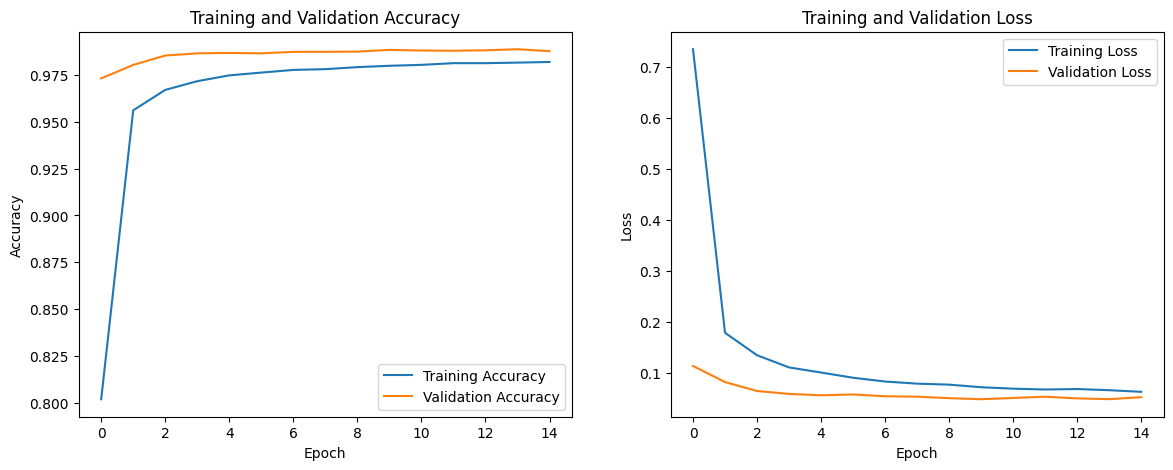

In [ ]:
import matplotlib.pyplot as plt

# --- Check if 'history' object exists ---
if 'history' not in locals():
    print("ERROR: 'history' object not found.")
    print("Please re-run Cell 4 (Model Training) before running this cell.")
else:
    # --- Get the data from the history object ---
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    # --- Create the plots ---
    plt.figure(figsize=(14, 5))

    # Plot 1: Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    # Plot 2: Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.show()

Loading model: /content/drive/MyDrive/isl_model_no_aug.h5
Loading data: /content/drive/MyDrive/landmark_data_no_aug.npz
Loading labels: /content/drive/MyDrive/labels_no_aug.json

Re-creating train/test split...
Successfully loaded 8591 test samples.
Generating predictions on test data...
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

--- Overall Model Metrics Summary ---
Overall Accuracy:   98.848%
Macro Avg Precision:  0.990
Macro Avg Recall:     0.989
Macro Avg F1-Score:   0.989
Weighted Avg Precision: 0.990
Weighted Avg Recall:    0.988
Weighted Avg F1-Score:  0.989
-----------------------------------

--- Detailed Classification Report (Per-Character) ---
              precision    recall  f1-score   support

           1      1.000     1.000     1.000       252
           2      0.996     1.000     0.998       251
           3      1.000     1.000     1.000       241
           4      1.000     1.000     1.000       233
           5      1.000     1.000     1.000       245
           6

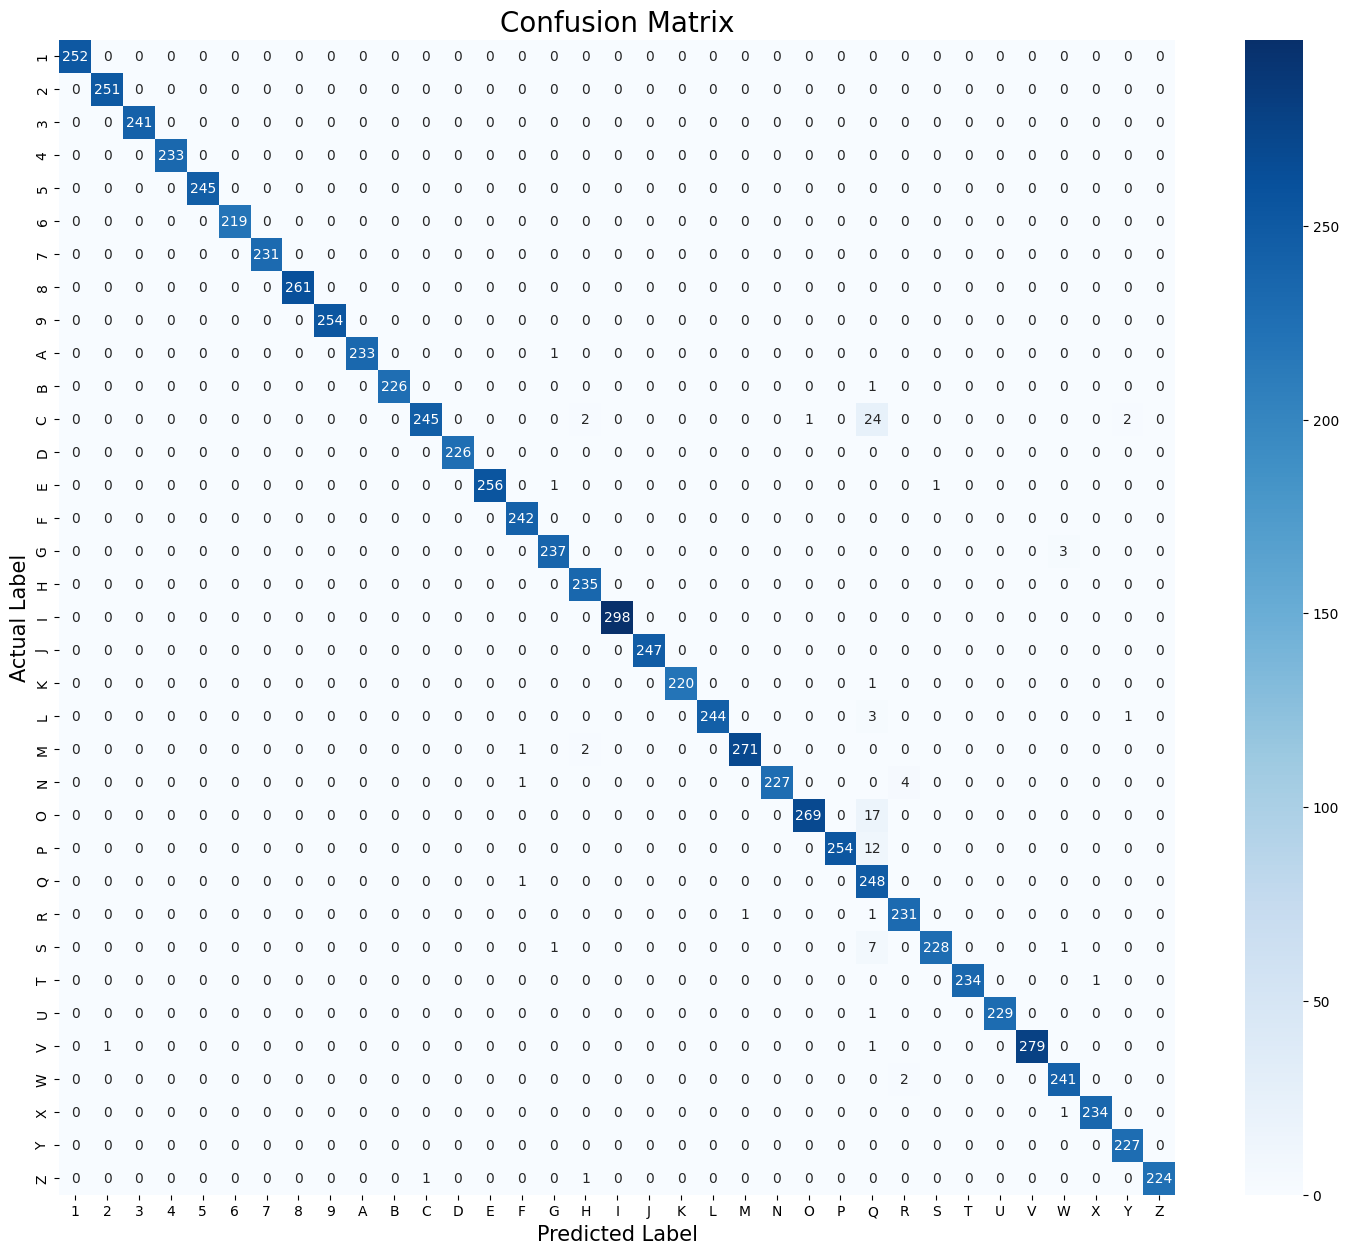

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
# --- New imports for summary metrics ---
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import json
import os

# --- 1. CONFIGURE FILE PATHS ---
# Make sure these paths point to the model you want to test

# Option 1: Your Non-Augmented Model
MODEL_PATH    = '/content/drive/MyDrive/isl_model_no_aug.h5'
DATA_NPZ      = '/content/drive/MyDrive/landmark_data_no_aug.npz'
LABELS_JSON   = '/content/drive/MyDrive/labels_no_aug.json'

# Option 2: Your Augmented Model (uncomment the 3 lines below to use)
# MODEL_PATH    = '/content/drive/MyDrive/isl_model_2hand.h5'
# DATA_NPZ      = '/content/drive/MyDrive/landmark_data_2hand.npz'
# LABELS_JSON   = '/content/drive/MyDrive/labels_2hand.json'

print(f"Loading model: {MODEL_PATH}")
print(f"Loading data: {DATA_NPZ}")
print(f"Loading labels: {LABELS_JSON}")

# --- 2. Load Model, Data, and Labels ---
try:
    # Mount drive first if you're in a new notebook
    if not os.path.exists('/content/drive'):
        from google.colab import drive
        drive.mount('/content/drive')

    model = tf.keras.models.load_model(MODEL_PATH)
    data = np.load(DATA_NPZ)
    X = data['X']
    y = data['y']

    with open(LABELS_JSON, 'r') as f:
        label_map_str = json.load(f)
        label_map = {int(k): v for k, v in label_map_str.items()}
    class_names = [label_map[i] for i in range(len(label_map))]

except FileNotFoundError as e:
    print(f"\n--- ERROR ---")
    print(f"File not found: {e.fileName}")
    print("Please make sure the paths at the top of the script are correct.")
    # Stop execution
    raise e

# --- 3. Re-create the *Exact* Test Split ---
# This is the most critical step.
# Using random_state=42 ensures we get the *exact same* X_test and y_test
# that the model was evaluated on during training.
print("\nRe-creating train/test split...")
_, X_test, _, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Successfully loaded {len(X_test)} test samples.")

# --- 4. Get Model Predictions ---
print("Generating predictions on test data...")
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# --- 5. Print Overall Model Summary Metrics ---
print("\n--- Overall Model Metrics Summary ---")
accuracy = accuracy_score(y_test, y_pred)
macro_precision = precision_score(y_test, y_pred, average='macro')
macro_recall = recall_score(y_test, y_pred, average='macro')
macro_f1 = f1_score(y_test, y_pred, average='macro')

weighted_precision = precision_score(y_test, y_pred, average='weighted')
weighted_recall = recall_score(y_test, y_pred, average='weighted')
weighted_f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Overall Accuracy:   {accuracy * 100:.3f}%")
print(f"Macro Avg Precision:  {macro_precision:.3f}")
print(f"Macro Avg Recall:     {macro_recall:.3f}")
print(f"Macro Avg F1-Score:   {macro_f1:.3f}")
print(f"Weighted Avg Precision: {weighted_precision:.3f}")
print(f"Weighted Avg Recall:    {weighted_recall:.3f}")
print(f"Weighted Avg F1-Score:  {weighted_f1:.3f}")
print("-" * 35)


# --- 6. Print Detailed Classification Report (Per-Character) ---
print("\n--- Detailed Classification Report (Per-Character) ---")
# 'digits=3' gives more precision
print(classification_report(y_test, y_pred, target_names=class_names, digits=3))

# --- 7. Plot Confusion Matrix ---
print("\n--- Generating Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(18, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=20)
plt.ylabel('Actual Label', fontsize=15)
plt.xlabel('Predicted Label', fontsize=15)
plt.show()

